In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

import xarray as xr
from scipy import signal, integrate

import subroutines
import vis_eulag 

plt.style.use('latex_default.mplstyle')

In [2]:
fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_003']
# fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_004']
SETTINGS = vis_eulag.load_settings('settings_translb3D.txt')

CENTER_STR_X = 0.53
CENTER_STR_Y = 0.5

ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap

    ds.attrs['cp'] = np.round(ds.attrs['cp'],3) # .round(3)
    ds.attrs['cap'] = np.round(ds.attrs['cap'])
    ds.attrs['capp'] = np.round(ds.attrs['capp'])
    ds.attrs['compri'] = np.round(ds.attrs['compri'])
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    # ds['pprime']=ds['p'] # h12
    # ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?
    
    # -- Filter -- # 
    # ds.attrs['nx_avg'] = int(ds.xml*4/ds.dy00)
    # ds.attrs['nz_avg'] = int(2*np.pi*ds['ue'][0,0,0,0]/ds.bv/ds.dz00)+1
    ds.attrs['nx_avg'] = int(600*1000/ds.dx00) # 600km
    ds.attrs['nz_avg'] = int(9000/ds.dz00)+1 # 12km
    
    ds_cp = ds.copy()
    ds_list.append(ds_cp)

0
1
2


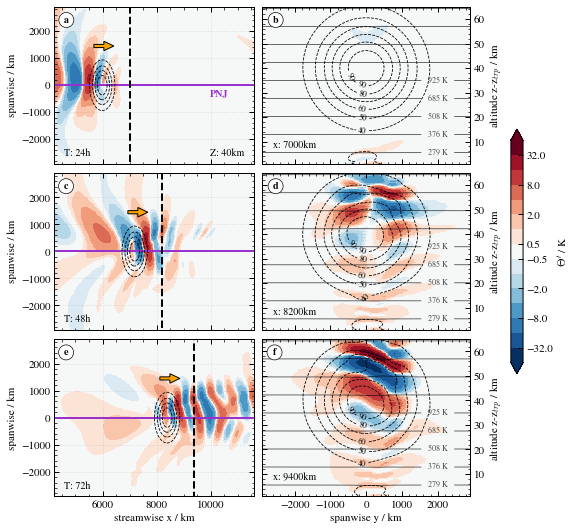

In [6]:
"Plots reference simulation for 3D simulations with TH and three time steps"
gskw = {'hspace':0.06, 'wspace':0.04, 'width_ratios': [4,4,0.6,0.8]}
fig, axes = plt.subplots(3,4, figsize=(9,9), gridspec_kw=gskw)
axes[0,2].set_axis_off()
axes[1,2].set_axis_off()
axes[2,2].set_axis_off()
axes[0,3].set_axis_off()
axes[1,3].set_axis_off()
axes[2,3].set_axis_off()

tvec = [2,4,6]
z = 133 # dz=300m 67=20km, 33=10km
z_l = 40 # km    

# y_jet = -1500
y_jet = 0

levels_jet=[40,50,60,70,80,90]
# levels_jet=[40,60,80,100,120]

ZLIM = [1,65]
YLIM = [-2900,2900]
XLIM = [4200,11600]

lee_pos=1000 # km
x1 = (-2400+50*24+lee_pos+ds.nx/2*ds.dx00/1000)
x2 = (-2400+50*48+lee_pos+ds.nx/2*ds.dx00/1000)
x3 = (-2400+50*72+lee_pos+ds.nx/2*ds.dx00/1000)
xvec_l = [x1,x2,x3] # position of TD at corresponding points in time  
# xvec_l = [5000,7200,9500]

i=0
xvec = []
for x in xvec_l:
    xvec.append(int(xvec_l[i]*1000/ds.dx00))
    i+=1
    
cmap = plt.get_cmap('RdBu_r')

ds = ds_list[0]

numb_str = ['a','b','c','d','e','f']
k=0
i=0 # rows
for t in tvec:
    print(i)
    x=xvec[i]
    
    ### -- Theta -- ###
    j=0 # columns
    clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
    norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

    pcMesh0 = axes[i,j].pcolormesh(ds.xcr, ds.ycr, ds.th[t,z,:,:],
                     cmap=cmap, norm=norm, shading='nearest')
    
    lw=2
    axes[i,j].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='-', lw=lw, colors='darkorchid')
    axes[i,j].vlines(x=xvec_l[i],ymin=ds.ycr.min(),ymax=ds.ycr.max(), linestyles='--', lw=lw, colors='black')
    
    axes[i,j] = subroutines.format_xy_plot(ds, SETTINGS, axes[i,j], t, z=z)
    axes[i,j].axis('scaled')
    axes[i,j].set_xlim(XLIM)
    axes[i,j].set_ylim(YLIM)
    # axes[i,j].set_title('T: ' + str(t*12) + 'h',pad=10)
    axes[i,j].set_ylabel('spanwise / km')
    axes[i,j].text(0.05,0.05,'T: ' + str(t*12) + 'h', transform=axes[i,j].transAxes)
    
    if i!=2:
        axes[i,j].tick_params(axis="x", which='both', labelbottom=False)
    
    if i==0: 
        axes[i,j].text(0.78,0.05,'Z: ' + str(z_l) + 'km', transform=axes[i,j].transAxes)
        # axes[i,j].text(0.78,0.28,'PNJ', weight='bold',color='darkorchid', transform=axes[i,j].transAxes)
        axes[i,j].text(0.78,0.43,'PNJ', weight='bold',color='darkorchid', transform=axes[i,j].transAxes)
    
    axes[i,j].grid()
    # axes[i,j].arrow(xvec_l[i]-lee_pos, 1500, 100, 0, width = 150, head_length=50, color='orange')
    
    axes[i,j].text(0.05, 0.9, numb_str[k], transform=axes[i,j].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    k=k+1
    
    ### -- Vertical cross section -- ###
    j=1
    # clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
    # norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)
    
    pcMesh1 = axes[i,j].pcolormesh(ds.ycr[:,x], ds.zcr[t,:,:,x], ds.th[t,:,:,x],
                     cmap=cmap, norm=norm, shading='nearest')
    
    cont1 = axes[i,j].contour(ds.ycr[:,0],ds.zcr[t,:,0,x],ds['u'][t,:,:,x].values,
                              linestyles='dashed', colors='k',  levels=levels_jet)
    wind_z_pos = np.linspace(15,38,6)
    wind_label = []
    for pos in wind_z_pos:
        # wind_label.append((-2000,pos))
        wind_label.append((-100,pos))
    axes[i,j].clabel(cont1, fmt='%1.0f', inline_spacing=0, inline=True, fontsize=8, manual=wind_label)
    axes[i,j] = subroutines.format_yz_plot(ds, SETTINGS, axes[i,j], t, x=x)
    # axes[i,j].set_aspect(aspect=80)
    
    axes[i,j].set_ylim(ZLIM)
    axes[i,j].set_xlim(YLIM)
    axes[i,j].set_ylabel(r'altitude z-z$_{trp}$ / km')
    axes[i,j].yaxis.set_label_position("right")
    axes[i,j].tick_params(axis="y", which='both', labelleft=False, labelright=True)
    axes[i,j].text(0.05,0.1,'x: ' + str(int(xvec[i]*ds.dx00/1000)) + 'km', transform=axes[i,j].transAxes)
    
    if i!=2:
        axes[i,j].tick_params(axis="x", which='both', labelbottom=False)
    
    axes[i,j].text(0.05, 0.9, numb_str[k], transform=axes[i,j].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    k=k+1
    i+=1

cbar2 = fig.colorbar(pcMesh1, ax=axes[:,3], shrink=0.5, fraction=1, ticks=clev_l, extend='both')
# cbar2.set_label("$\Theta'$ / K (top)  +++  E$_P$ / J kg$^{-1}$ (bottom)")
cbar2.set_label("$\Theta'$ / K")

axes[2,0].set_xlabel('streamwise x / km')
axes[2,1].set_xlabel('spanwise y / km')

axes[0,0].arrow(0.2, 0.75, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,0].transAxes, facecolor='orange', edgecolor='black')
axes[1,0].arrow(0.37, 0.75, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[1,0].transAxes, facecolor='orange', edgecolor='black')
axes[2,0].arrow(0.53, 0.75, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[2,0].transAxes, facecolor='orange', edgecolor='black')
    
# --- Save fig --- #
# fig_name = '3D-th-PNJ-south.png'
# fig_name = '3D-th-referenceSim.png'
fig_name = '3D-th-PNJ-centered.png'
fig.savefig('../figures/' + fig_name, facecolor='w', edgecolor='w',
            format='png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 251, y: 480, x: 720)
Coordinates:
    xcr        (y, x) float32 0.0 20.0 40.0 ... 1.434e+04 1.436e+04 1.438e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -4.79e+03 -4.79e+03 ... 4.79e+03 4.79e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/19)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rhe        (t, z, y, x) float32 ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.838e+04 2.838e+04 ... 0.6307 0.6307
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 3.158e+04
Attributes: (12/56)
    nt:           4320
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         20000.0
    ...           ...
    capi:         3.5
    capp:         1.0
    cappi:        1.4
    compri:       11.0
    nx_avg:       30
    nz_avg:       31

In [ ]:
"Plots 3 xy (th') and 3 yz (Ep) plots for three points in time"
tvec = [2,4,6]
z = 133 # dz=300m 67=20km, 33=10km
z_l = 40 # km    

y_jet = -1500
# y_jet = 0

levels_jet=[40,50,60,70,80,90]
# levels_jet=[40,60,80,100,120]

ZLIM = [0,75]
YLIM = [-3500,3500]

lee_pos=1500 # km
x1 = (-2400+50*24+lee_pos+ds.nx/2*ds.dx00/1000)
x2 = (-2400+50*48+lee_pos+ds.nx/2*ds.dx00/1000)
x3 = (-2400+50*72+lee_pos+ds.nx/2*ds.dx00/1000)
xvec_l = [x1,x2,x3] # position of TD at corresponding points in time  
# xvec_l = [5000,7200,9500]

i=0
xvec = []
for x in xvec_l:
    xvec.append(int(xvec_l[i]*1000/ds.dx00))
    i+=1
    
cmap = plt.get_cmap('RdBu_r')

ds = ds_list[0]

# gskw = {'hspace':0.2, 'wspace':0.09, 'height_ratios': [3,5.5,0.3,1]}
fig, axes = plt.subplots(4,3, figsize=(10,6), gridspec_kw=gskw)
axes[2,0].set_axis_off()
axes[2,1].set_axis_off()
axes[2,2].set_axis_off()
axes[3,0].set_axis_off()
axes[3,1].set_axis_off()
axes[3,2].set_axis_off()

j=0
for t in tvec:
    # -- Theta -- #
    i=0
    clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
    norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

    pcMesh0 = axes[i,j].pcolormesh(ds.xcr, ds.ycr, ds.th[t,z,:,:],
                     cmap=cmap, norm=norm, shading='nearest')

    axes[i,j].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='-', lw=1.3, colors='darkorchid')
    axes[i,j].vlines(x=xvec_l[j],ymin=ds.ycr.min(),ymax=ds.ycr.max(), linestyles='--', lw=1.3, colors='black')
    
    axes[i,j] = subroutines.format_xy_plot(ds, SETTINGS, axes[i,j], t, z=z)
    axes[i,j].axis('scaled')
    
    axes[i,j].set_title('T: ' + str(t*12) + 'h',pad=10)
    axes[i,j].set_xlabel('streamwise x / km')
    axes[i,j].xaxis.set_label_position('top') 
    axes[i,j].tick_params(labelbottom=False,labeltop=True)
    
    if j==0:
        axes[i,j].set_ylabel('spanwise / km')
        axes[i,j].text(0.05,0.05,'Z: ' + str(z_l) + 'km', transform=axes[i,j].transAxes)
        axes[i,j].annotate('PNJ',(11500,y_jet-750), weight='bold',color='darkorchid')
    else:
        axes[i,j].tick_params(axis="y", which='both', labelleft=False)
    axes[i,j].set_ylim(YLIM)
    
    # -- Vertical cross section -- #
    i=1
    x=xvec[j]
    
    clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
    norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)
    
    # --------- Calculate fluxes -------------------- #                           
    thloc = ds['the'][t,:,:,x] + ds['th'][t,:,:,x] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,:,:,x]*(ds['pr0'][t,:,:,x]/ds['pref00'])**ds.cap # T_env
    tloc = thloc*(ds['pr0'][t,:,:,x]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte

    ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'].expand_dims({'t':ds.t}) potential energy density
    ep=subroutines.fft_gaussian_filter(ep,ds.nz_avg,nx_avg=ds.nx_avg,usey=1)
    # --------- Calculate and filter fluxes -------------------- #
    
    pcMesh1 = axes[i,j].pcolormesh(ds.ycr[:,x], ds.zcr[t,:,:,x], ds.th[t,:,:,x],
                     cmap=cmap, norm=norm, shading='nearest')
    
    cont1 = axes[i,j].contour(ds.ycr[:,0],ds.zcr[t,:,0,x],ds['u'][t,:,:,x].values,
                              linestyles='dashed', colors='k', alpha=0.7,  levels=levels_jet)
    axes[i,j].clabel(cont1, fontsize=9, fmt='%1.0f', inline_spacing=6, inline=True)
    
    axes[i,j] = subroutines.format_yz_plot(ds, SETTINGS, axes[i,j], t, x=x)
    # axes[i,j].set_aspect(aspect=80)

    axes[i,j].text(0.05,0.03,'x: ' + str(int(xvec[j]*ds.dx00/1000)) + 'km', transform=axes[i,j].transAxes)
    axes[i,j].set_xlabel('spanwise y / km')
    axes[i,j].set_ylim(ZLIM)
    axes[i,j].set_xlim(YLIM)
    
    if j==0:
        axes[i,j].set_ylabel('altitude / km')
    else:
        axes[i,j].tick_params(axis="y", which='both', labelleft=False)
    j+=1

clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
cbar2 = fig.colorbar(pcMesh1, ax=axes[3,:], location='bottom', shrink=0.5, pad=0.1, fraction=1, ticks=clev_l)
# cbar2.set_label("$\Theta'$ / K (top)  +++  E$_P$ / J kg$^{-1}$ (bottom)")
cbar2.set_label("$\Theta'$ / K")

# - YLABELS LEFT - #
fig.canvas.draw()
height_tick = axes[1,0].get_yticks()
height_tick_labels = axes[1,0].get_yticklabels()
height_tick_labels[1] = r"0 (z$_{trp}$)"
axes[1,0].set_yticks(height_tick)
axes[1,0].set_yticklabels(height_tick_labels)
axes[1,0].set_ylim(ZLIM)

axes[0,0].arrow(0.37, 0.85, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,0].transAxes, color='orange')
axes[0,1].arrow(0.46, 0.85, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,1].transAxes, color='orange')
axes[0,2].arrow(0.55, 0.85, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,2].transAxes, color='orange')

# --- Add text --- #
# center_str = 'T: ' + str(int(ds.dt00*t*ds.nplot/3600)) +'h, z: ' + str(int(ds.dz00*z/1000)) + 'km' 
# fig.text(CENTER_STR_X,CENTER_STR_Y,center_str,horizontalalignment='center',
#         verticalalignment='center', ma='center', fontsize=14)

# --- Save fig --- #
# fig_name = '3D-th-PNJ-south.png'
fig_name = '3D-th-PNJ-centered-empty.png'
# plt.show()
fig.savefig('../figures/' + fig_name, facecolor='w', edgecolor='w',
            format='png', dpi=450, bbox_inches='tight')

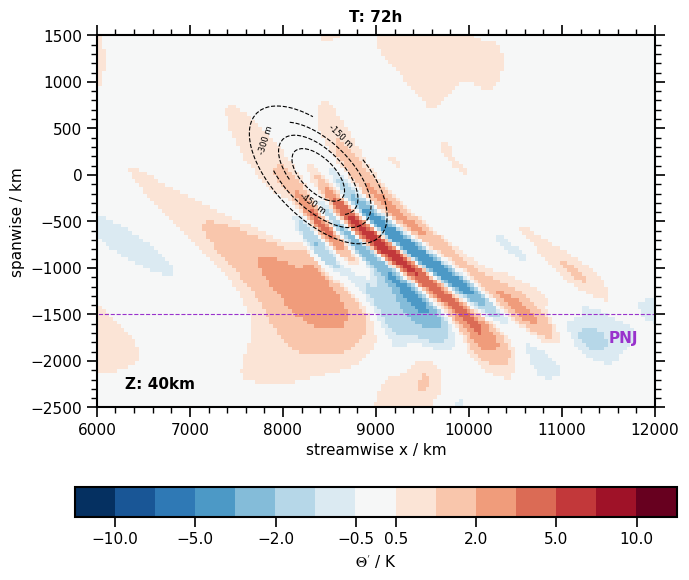

In [7]:
"Plots 3 xy (th') and 3 yz (Ep) plots for three points in time"
z = 133 # dz=300m 67=20km, 33=10km
z_l = 40 # km    
t= 6
    
cmap = plt.get_cmap('RdBu_r')

ds = ds_list[0]
fig, ax = plt.subplots(1,1, figsize=(8,6))

# -- Theta -- #
clev = eval(SETTINGS['CLEV_TH'])
clev_l = eval(SETTINGS['CLEV_TH'] + '_LABELS')
norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

pcMesh0 = ax.pcolormesh(ds.xcr, ds.ycr, ds.th[t,z,:,:],
                 cmap=cmap, norm=norm, shading='nearest')
ax.hlines(y=-1500,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', colors='darkorchid')


ax = format_xy_plot(ds, SETTINGS, ax, t, z=z)
ax.axis('scaled')
ax.set_xlim((6000,12000))
ax.set_ylim((-2500,1500))

ax.set_title('T: ' + str(t*12) + 'h', weight='bold',pad=10)
ax.set_xlabel('streamwise x / km')
ax.set_ylabel('spanwise / km')
ax.text(0.05,0.05,'Z: ' + str(z_l) + 'km', transform=ax.transAxes, weight='bold')
ax.annotate('PNJ',(11500,-1800), weight='bold',color='darkorchid')     

clev_l = eval(SETTINGS['CLEV_TH'] + '_LABELS')
cbar = fig.colorbar(pcMesh0, ax=ax, orientation='horizontal', ticks=clev_l, shrink=0.8) #  pad=-0.7, shrink=0.66)
cbar.set_label("$\Theta'$ / K")


# --- Save fig --- #
fig_name = '3D_th_RF25.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_name, facecolor='w', edgecolor='w',
            format='png', dpi=150) # orientation='portrait'

In [ ]:
# - YLABELS LEFT - #
fig.canvas.draw()
height_tick = axes[0,1].get_yticks()
height_tick_labels = axes[0,1].get_yticklabels()
height_tick_labels[1] = r"0 (z$_{trp}$)"
for i in range(0,3):  
    axes[i,1].set_yticks(height_tick)
    axes[i,1].set_yticklabels(height_tick_labels)
    axes[i,1].set_ylim(ZLIM)